# Expectation maximization

$$ \begin{eqnarray} 
 z_i &\sim & Multinomial(\phi) \\
 x_i|z_i & \sim & \mathcal{N}(\mu_{z_i}, \sigma_{z_i})) \\
\end{eqnarray}$$ 


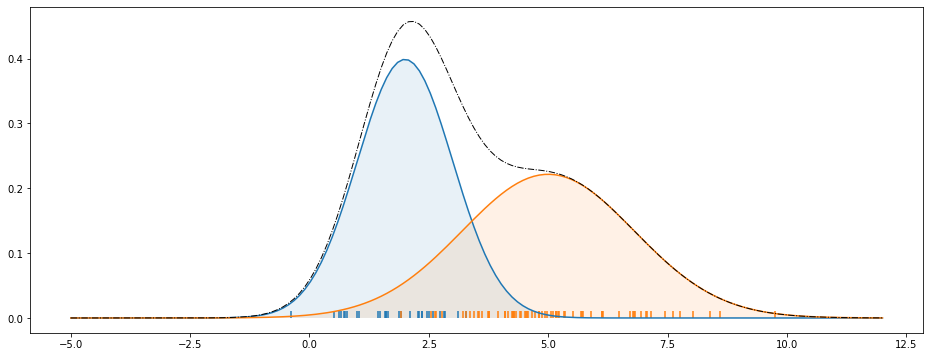

In [379]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

np.random.seed(654)
# Draw samples from two Gaussian w.p. z_i ~ Bernoulli(phi)
generative_m = np.array([stats.norm(2, 1), stats.norm(5, 1.8)])
z = stats.bernoulli(0.75).rvs(100)
x_i = np.array([g.rvs() for g in generative_m[z_i]])

# plot generated data and the latent distributions
x = np.linspace(-5, 12, 150)
plt.figure(figsize=(16, 6))
plt.plot(x, generative_m[0].pdf(x))
plt.plot(x, generative_m[1].pdf(x))
plt.plot(x, generative_m[0].pdf(x) + generative_m[1].pdf(x), lw=1, ls='-.', color='black')
plt.fill_betweenx(generative_m[0].pdf(x), x, alpha=0.1)
plt.fill_betweenx(generative_m[1].pdf(x), x, alpha=0.1)
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z])
plt.show()

# Log likelihood
Let $\theta = \{ \mu, \sigma \}$.
$$\ell(\theta) = \sum_{i-1}^n \log P(x_i; \theta)  $$

Or in vector form:

$$\ell(\theta) = \log P(x; \theta)  $$

This log likelihood function cannot be solved directly as it not includes the latent variable $z$.

$$ \ell(\theta) = \sum_{k=1}^K \log P(x | z_k; \theta) P(z_k) $$

## Continuous form

$$ \begin{eqnarray}
\ell(\theta) & = & \int \log P(x | \theta, z) P(z) dz \\
\log P(x; \theta)& = & \int \log P(x | \theta, z) P(z) dz
\end{eqnarray}$$





**Jensens inequality:**
*Only for concave functions*
$$ E[f(X)] \le f(E[X]) $$

**Jensens equality:**
$$ E[f(X)] = f(E[X]) \iff X = E[X] $$

## Evidence Lower BOund


Multiply the **evidence** w/ an arbitrary distribution over $Z, \quad \frac{Q(z)}{Q(z)} = 1$ 

$$ \begin{eqnarray}
\log P(x; \theta)& = & \int \log Q(z) \frac{ P(x | \theta, z) P(z)}{Q(z)} dz \\
& = & \log E_{z \sim Q}[ \frac{ P(x | \theta, z) P(z)}{Q(z)}] \\
\end{eqnarray}$$

As the log function is a concave function, we can apply Jensen's inequality.

$$ \begin{eqnarray}
\log P(x; \theta)& = & \log E_{z \sim Q}[ \frac{ P(x | \theta, z) P(z)}{Q(z)}] \\
& \ge &  E_{z \sim Q}[ \log \frac{ P(x | \theta, z) P(z)}{Q(z)}]
\end{eqnarray}$$



Resulting in a lower bound on the evidence called the **ELBO**:

$$ \begin{eqnarray}
\log P(x; \theta)& \ge &  E_{z \sim Q}[ \log \frac{ P(x | \theta, z) P(z)}{Q(z)}]
\end{eqnarray}$$


# Now what?

Jensen's inequality holds to equaltiy if and only if $X = E[X]$. This will be the case if we choose a distribution that leads to:

$$ \begin{eqnarray}
\frac{P(x|z) P(z)}{Q(z)} &=& \frac{P(x, z)}{Q(z)} = 1
\end{eqnarray}$$

Wich means that 

$$ P(x, z; \theta) \propto Q(z) $$

A next requirement is that $\int Q(z) dz = 1$ (requirement of probability distribution).

$$ \begin{eqnarray}
\int \frac{P(x, z; \theta)}{\int P(x, z; \theta) dz} dz &=& 1 \\
\end{eqnarray}$$

This will lead to:

$$ \begin{eqnarray}
Q(z) &=& \frac{P(x, z; \theta)}{\int P(x, z; \theta) dz}  \\
&=& \frac{P(x, z; \theta)}{\int P(x; \theta)} \\
&=& P(z|x; \theta)
\end{eqnarray}$$

## Gaussian mixture model

### Expectation
Given a Gaussian mixture model, observed data points $x$ and current parameters $\theta_t$ find $Q(z)$

In [377]:
# Data points x
x_i

array([ 4.28244273,  4.66972656,  3.35275075,  2.36158676,  3.74751768,
        9.75240814,  5.15756521,  4.80213993,  5.90145058,  1.91271217,
        4.71273852,  2.36241133,  1.61084671,  6.71697406,  3.11442326,
        5.15422491,  5.09580485,  2.11274369,  6.76574344,  1.48354695,
        2.65304672,  6.81892055,  2.77103106,  5.06418788,  5.72517362,
        3.54313443,  5.67858554,  1.03222311,  1.63983108,  5.51107055,
        0.65124788,  4.97843073,  4.32989217,  2.28812021,  4.51797044,
        4.52825271,  6.93340533,  4.94273792,  2.54969132,  0.78634279,
        4.81172184,  5.19576022,  6.11967179,  3.5235398 ,  0.75307613,
        4.23428727,  7.15230773,  2.83345813,  8.60608829,  4.27073679,
        7.75388195,  6.79259227,  0.62404892,  4.26260727,  4.09584051,
        3.26993383,  4.86431429,  8.38977374,  6.48961063,  4.09783105,
        4.40498267,  3.27433241,  7.44164281,  7.62286463,  3.21797707,
        4.42538064,  7.06135769,  3.94733606,  1.91385988,  5.23

In [266]:
import torch
from torch import nn
import torch.distributions as dist
import torch.nn.functional as F

In [363]:
x_i = torch.tensor(x_i, dtype=torch.float)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


<BarContainer object of 100 artists>

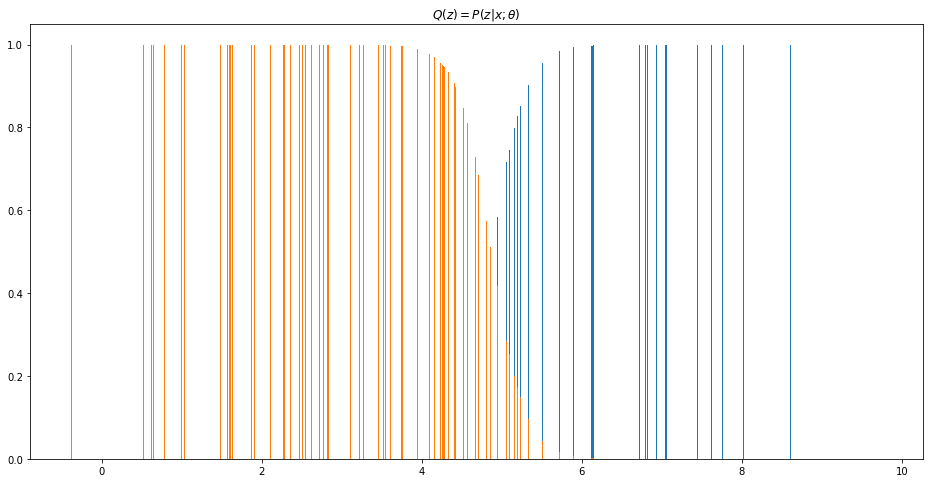

In [364]:
torch.manual_seed(1)

k = torch.tensor([2])
mu = dist.Uniform(x_i.min(), x_i.max()).sample(k) 
std = torch.ones(k)

def expectation(x, mu, std, k):
    qz = torch.zeros((k, x.shape[0]))
    
    for z in range(k):
        qz[z] = dist.Normal(mu[z], std[z]).log_prob(x).exp() 
    
    # normalize zo that marginalizing z would lead to p = 1
    qz = qz / qz.sum(0)
    return qz

qz = expectation(x_i, mu, std, k)    

plt.figure(figsize=(16, 8)) 
plt.title(r"$Q(z) = P(z|x; \theta)$")
plt.bar(x_i, qz[0], width=0.01)
plt.bar(x_i, qz[1], width=0.01)

### Maximization

Optimize $\theta$ with the $Q(z)$ found in the expectation step.

$$ \sum_{z_i} Q(z_i) \log ( \frac{p(x_i| z_i; \theta) p(z_i)}  {Q(z_i)}) $$

In [370]:
k = torch.tensor([2])
mu = dist.Uniform(x_i.min(), x_i.max()).sample(k) 
std = torch.ones(k)
mu = torch.tensor(mu, dtype=torch.float, requires_grad=True)
std = torch.tensor([1., 1.])
std = torch.tensor(std, dtype=torch.float, requires_grad=True)
phi = torch.rand(2, requires_grad=True)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [371]:
def get_elbo(mu, std, phi):
    elbo = 0
    for k in range(2):
        z_i = F.softmax(phi)[k]
        mu_i = mu[k]
        std_i = std[k]
        
        for i in range(len(x_i)):
            elbo += qz[k, i] * ((dist.Normal(mu_i, std_i).log_prob(x_i[i]) + torch.log(z_i) - torch.log(qz[k, i])))
    return elbo

elbo = get_elbo(mu, std, phi)
elbo

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


tensor(-512.5377, grad_fn=<AddBackward0>)

In [372]:
lr = 0.01
for i in range(10):
    
    # expectation step
    with torch.no_grad():
        qz = expectation(x_i, mu, std, k)
    
    # maximization step
    for j in range(150):
        negative_elbo = -get_elbo(mu, std, phi)
        negative_elbo.backward()
    
        with torch.no_grad():
            mu -= mu.grad * lr 
            std -= std.grad * lr
            phi -= phi.grad * lr
            std.grad.zero_()
            mu.grad.zero_()
            phi.grad.zero_()

    print(negative_elbo.item(), mu.data, std.data, F.softmax(phi).data)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


215.0631103515625 tensor([5.8801, 2.9457]) tensor([1.5491, 1.5054]) tensor([0.3965, 0.6035])
214.99671936035156 tensor([5.6912, 2.8268]) tensor([1.5984, 1.4784]) tensor([0.4478, 0.5522])
214.94085693359375 tensor([5.5913, 2.7706]) tensor([1.6360, 1.4637]) tensor([0.4746, 0.5254])
214.90855407714844 tensor([5.5367, 2.7465]) tensor([1.6611, 1.4576]) tensor([0.4884, 0.5116])
214.89120483398438 tensor([5.5059, 2.7380]) tensor([1.6776, 1.4564]) tensor([0.4954, 0.5046])
214.88137817382812 tensor([5.4879, 2.7368]) tensor([1.6889, 1.4577]) tensor([0.4989, 0.5011])
214.87564086914062 tensor([5.4766, 2.7388]) tensor([1.6970, 1.4600]) tensor([0.5006, 0.4994])
214.8721160888672 tensor([5.4690, 2.7420]) tensor([1.7031, 1.4625]) tensor([0.5014, 0.4986])
214.8697509765625 tensor([5.4635, 2.7455]) tensor([1.7079, 1.4651]) tensor([0.5018, 0.4982])
214.8681182861328 tensor([5.4594, 2.7489]) tensor([1.7118, 1.4674]) tensor([0.5019, 0.4981])


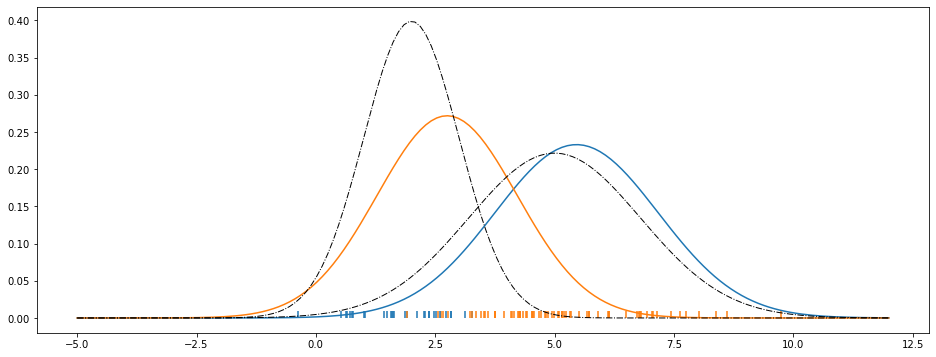

In [384]:
fitted_m = [stats.norm(mu, std) for mu, std in zip(mu.data, std.data)]

plt.figure(figsize=(16, 6))
plt.vlines(x_i, 0, 0.01, color=np.array(['C0', 'C1'])[z])
plt.plot(x, fitted_m[0].pdf(x))
plt.plot(x, fitted_m[1].pdf(x))
plt.plot(x, generative_m[0].pdf(x), color='black', lw=1, ls='-.')
plt.plot(x, generative_m[1].pdf(x), color='black', lw=1, ls='-.')
